Majority Voting Classifier Accuracy: 0.7333333333333333


C:\Users\TSHIFHIWA AUSTIN\AppData\Local\Temp\ipykernel_19984\2453863136.py:89: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y==cl, 0], y=X[y==cl, 1],


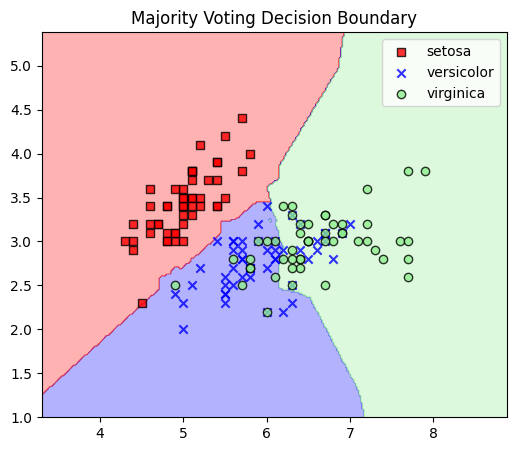

In [31]:
#PART 1: Implementing a Majority Vote Classifier
#Step 1.2: Implement Majority Voting Classifier
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.base import BaseEstimator, ClassifierMixin, clone
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import _name_estimators
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Majority Vote Classifier
class MajorityVoteClassifier(BaseEstimator, ClassifierMixin):
    """A majority vote ensemble classifier"""
    def __init__(self, classifiers, vote='classlabel', weights=None):
        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, value in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights

    def fit(self, X, y):
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self

    def predict(self, X):
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:
            predictions = np.asarray([clf.predict(X) for clf in self.classifiers_]).T
            maj_vote = np.apply_along_axis(
                lambda x: np.argmax(np.bincount(x, weights=self.weights)),
                axis=1, arr=predictions)
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote

    def predict_proba(self, X):
        probas = np.asarray([clf.predict_proba(X) for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba

# Load Iris dataset
iris = load_iris()
X, y = iris.data[:, :2], iris.target   # use first 2 features for visualization
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

# Define classifiers
clf1 = LogisticRegression(max_iter=1000, random_state=1)
clf2 = DecisionTreeClassifier(max_depth=3, random_state=1)
clf3 = KNeighborsClassifier(n_neighbors=5)

# Majority Vote
mv_clf = MajorityVoteClassifier(classifiers=[clf1, clf2, clf3])
mv_clf.fit(X_train, y_train)
y_pred = mv_clf.predict(X_test)
print("Majority Voting Classifier Accuracy:", accuracy_score(y_test, y_pred))

# Visualization
def plot_decision_regions(X, y, classifier, title, resolution=0.02):
    markers = ('s', 'x', 'o')
    colors = ('red', 'blue', 'lightgreen')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    # fit
    classifier.fit(X, y)
    
    # grid
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y==cl, 0], y=X[y==cl, 1],
                    alpha=0.8, c=colors[idx],
                    marker=markers[idx], label=iris.target_names[cl],
                    edgecolor='black')
    plt.title(title)
    plt.legend()

plt.figure(figsize=(6,5))
plot_decision_regions(X, y, mv_clf, "Majority Voting Decision Boundary")
plt.show()


In [4]:
#Step 1.3: Prepare the Iris Dataset

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Load Iris dataset
iris = datasets.load_iris()
X, y = iris.data[50:, [1, 2]], iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1, stratify=y)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)


X_train shape: (70, 2)
X_test shape: (30, 2)


10-fold cross validation:

ROC AUC: 0.94 (+/- 0.07) [Logistic Regression]
ROC AUC: 0.90 (+/- 0.12) [Decision Tree]
ROC AUC: 0.86 (+/- 0.12) [KNN]


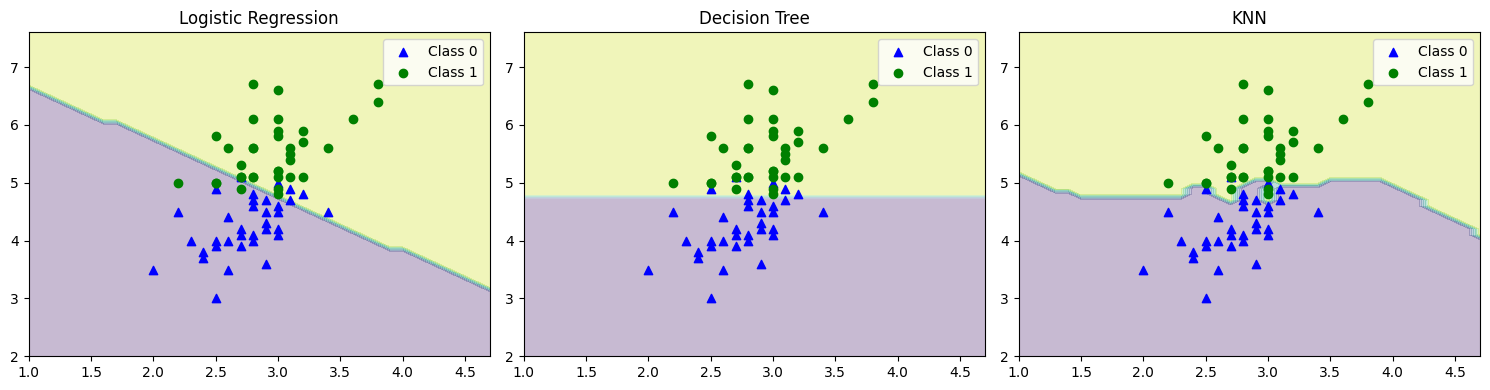

In [5]:
#Step 1.4: Training Individual Classifiers and Evaluating Performance

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

# Create individual classifiers
clf1 = LogisticRegression(penalty='l2', C=0.001, random_state=1)
clf2 = DecisionTreeClassifier(max_depth=1, criterion='entropy', random_state=0)
clf3 = KNeighborsClassifier(n_neighbors=1, p=2, metric='minkowski')

# Create pipelines
pipe1 = Pipeline([['sc', StandardScaler()], ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()], ['clf', clf3]])

clf_labels = ['Logistic Regression', 'Decision Tree', 'KNN']

print('10-fold cross validation:\n')
for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

# Visualization: Decision Boundaries for the 3 classifiers
def plot_classifier_boundary(clf, title):
    clf.fit(X_train, y_train)
    x_min, x_max = X_train[:,0].min()-1, X_train[:,0].max()+1
    y_min, y_max = X_train[:,1].min()-1, X_train[:,1].max()+1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.3)
    plt.scatter(X_train[y_train==0,0], X_train[y_train==0,1], c='blue', marker='^', label='Class 0')
    plt.scatter(X_train[y_train==1,0], X_train[y_train==1,1], c='green', marker='o', label='Class 1')
    plt.title(title)
    plt.legend()

plt.figure(figsize=(15,4))
for i, (clf, label) in enumerate(zip([pipe1, clf2, pipe3], clf_labels)):
    plt.subplot(1,3,i+1)
    plot_classifier_boundary(clf, label)
plt.tight_layout()
plt.show()


C:\Users\TSHIFHIWA AUSTIN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\TSHIFHIWA AUSTIN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_scorer.py", line 152, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "C:\Users\TSHIFHIWA AUSTIN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_scorer.py", line 400, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "C:\Users\TSHIFHIWA AUSTIN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-p


Majority Voting Classifier - ROC AUC: nan (+/- nan)


C:\Users\TSHIFHIWA AUSTIN\AppData\Local\Temp\ipykernel_19984\3072895968.py:36: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],


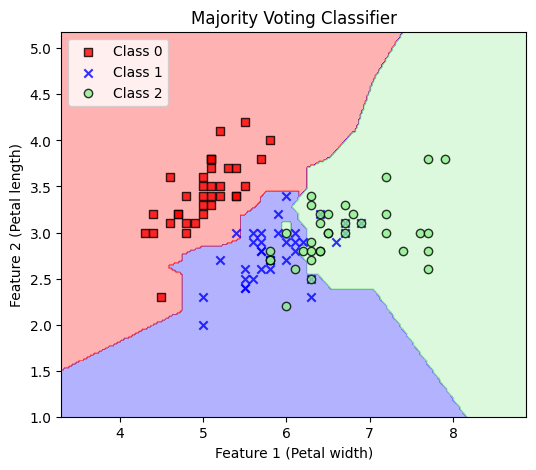

In [32]:

# Step 1.5: Train and Evaluate Majority Voting Classifier
# -------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import cross_val_score


# Create Majority Voting Classifier
mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3])

# Cross-validation evaluation
scores = cross_val_score(estimator=mv_clf, X=X_train, y=y_train, cv=10, scoring='roc_auc')
print("\nMajority Voting Classifier - ROC AUC: %.2f (+/- %.2f)" % (scores.mean(), scores.std()))

# --- Visualization: Decision Boundary ---
def plot_decision_regions(X, y, classifier, title, resolution=0.02):
    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.fit(X_train, y_train).predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, c=colors[idx],
                    marker=markers[idx], label=f"Class {cl}", edgecolor='black')

    plt.title(title)
    plt.xlabel("Feature 1 (Petal width)")
    plt.ylabel("Feature 2 (Petal length)")
    plt.legend(loc='upper left')

# Plot decision boundary for Majority Voting
plt.figure(figsize=(6, 5))
plot_decision_regions(X_train, y_train, classifier=mv_clf, title="Majority Voting Classifier")
plt.show()


Training set size: (95, 2)
Test set size: (24, 2)
Class distribution in y: {0: 71, 1: 48}


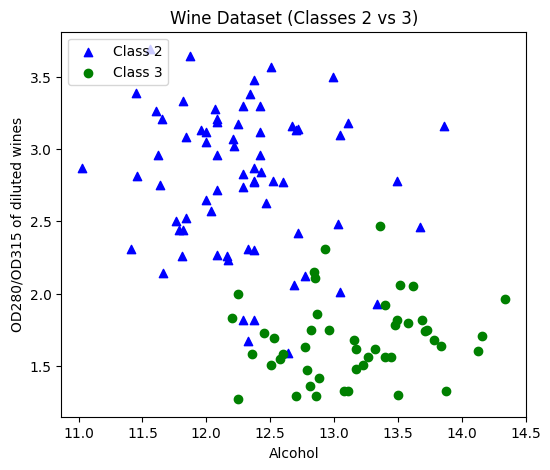

In [7]:
# Loading wine dataset and splitting into training and test sets

# Step 2.2: Prepare the Wine Dataset
# ----------------------------------
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Load Wine dataset from UCI repository
df_wine = pd.read_csv(
    'https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data',
    header=None
)

# Add column names
df_wine.columns = [
    'Class label', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash',
    'Magnesium', 'Total phenols', 'Flavanoids', 'Nonflavanoid phenols',
    'Proanthocyanins', 'Color intensity', 'Hue',
    'OD280/OD315 of diluted wines', 'Proline'
]

# Keep only classes 2 and 3 (binary classification problem)
df_wine = df_wine[df_wine['Class label'] != 1]

# Define features (2D for visualization later) and target
X = df_wine[['Alcohol', 'OD280/OD315 of diluted wines']].values
y = df_wine['Class label'].values

# Encode class labels as 0 and 1
le = LabelEncoder()
y = le.fit_transform(y)

# Split dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1, stratify=y
)

# Quick check of dataset shapes
print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)
print("Class distribution in y:", pd.Series(y).value_counts().to_dict())

# Visualization of dataset (scatter plot)
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
plt.scatter(X[y == 0, 0], X[y == 0, 1], color='blue', marker='^', label='Class 2')
plt.scatter(X[y == 1, 0], X[y == 1, 1], color='green', marker='o', label='Class 3')
plt.xlabel("Alcohol")
plt.ylabel("OD280/OD315 of diluted wines")
plt.title("Wine Dataset (Classes 2 vs 3)")
plt.legend(loc='upper left')
plt.show()


Decision Tree train/test accuracy: 1.000/0.833
Bagging train/test accuracy: 1.000/0.917


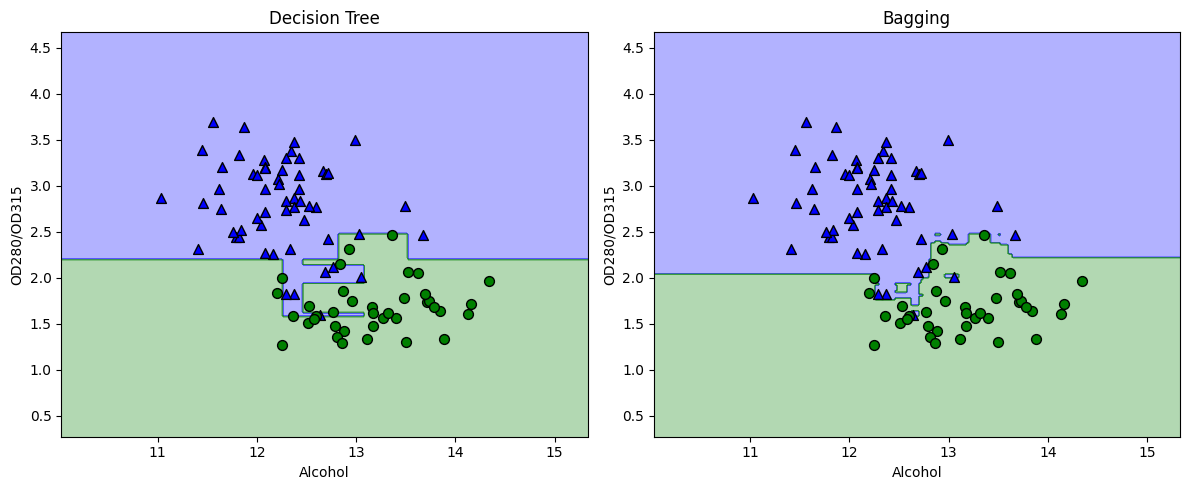

In [ ]:

# Step 2.3: Bagging with Decision Trees
# -------------------------------------
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Base decision tree (weak learner)
tree = DecisionTreeClassifier(criterion='entropy', 
                              max_depth=None, 
                              random_state=1)

bag = BaggingClassifier(
    estimator=tree,
    n_estimators=500,
    max_samples=1.0,
    max_features=1.0,
    bootstrap=True,
    n_jobs=-1,     # use all CPU cores for speed
    random_state=1
)

# Fit models
tree.fit(X_train, y_train)
bag.fit(X_train, y_train)

# Predictions
y_train_pred_tree = tree.predict(X_train)
y_test_pred_tree = tree.predict(X_test)

y_train_pred_bag = bag.predict(X_train)
y_test_pred_bag = bag.predict(X_test)

# Accuracies
tree_train_acc = accuracy_score(y_train, y_train_pred_tree)
tree_test_acc = accuracy_score(y_test, y_test_pred_tree)

bag_train_acc = accuracy_score(y_train, y_train_pred_bag)
bag_test_acc = accuracy_score(y_test, y_test_pred_bag)

print(f"Decision Tree train/test accuracy: {tree_train_acc:.3f}/{tree_test_acc:.3f}")
print(f"Bagging train/test accuracy: {bag_train_acc:.3f}/{bag_test_acc:.3f}")

# ------------------------------------
# Visualization: Decision boundaries
# ------------------------------------
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))

fig, axarr = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Plot decision surfaces for both models
for idx, clf, tt in zip([0, 1],
                        [tree, bag],
                        ['Decision Tree', 'Bagging']):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx].contourf(xx, yy, Z, alpha=0.3, cmap=ListedColormap(('blue', 'green')))
    axarr[idx].scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1],
                       c='blue', marker='^', edgecolor='k', s=50, label='Class 2')
    axarr[idx].scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1],
                       c='green', marker='o', edgecolor='k', s=50, label='Class 3')
    axarr[idx].set_title(tt)
    axarr[idx].set_xlabel("Alcohol")
    axarr[idx].set_ylabel("OD280/OD315")

plt.tight_layout()
plt.show()


C:\Users\TSHIFHIWA AUSTIN\AppData\Local\Temp\ipykernel_19984\2695779200.py:32: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axarr[idx].scatter(X_train[class_mask, 0], X_train[class_mask, 1],
C:\Users\TSHIFHIWA AUSTIN\AppData\Local\Temp\ipykernel_19984\2695779200.py:32: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axarr[idx].scatter(X_train[class_mask, 0], X_train[class_mask, 1],


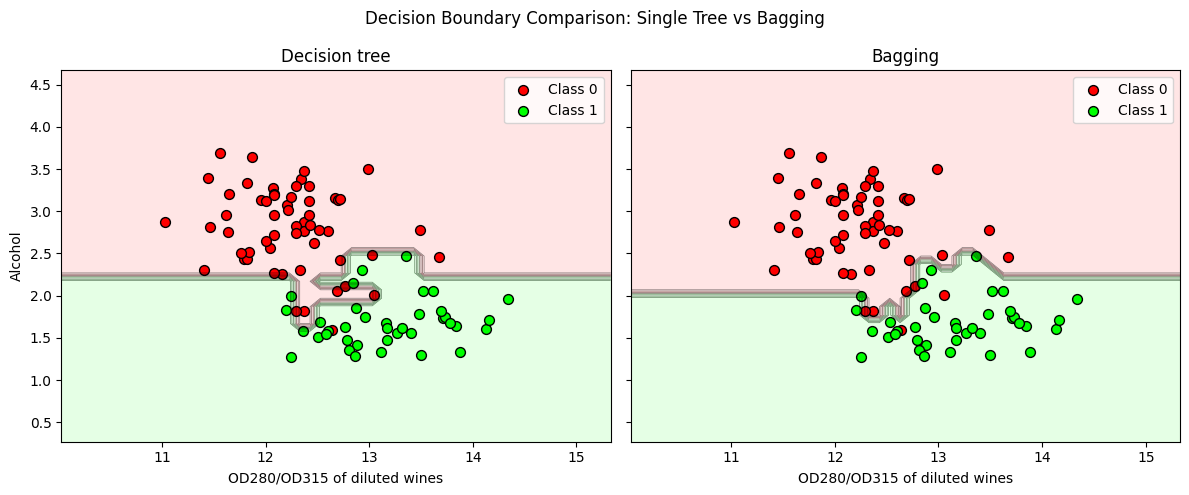

In [11]:
#Step 2.4: Visualizing Decision Boundaries

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

# Create mesh grid for plotting
x_min = X_train[:, 0].min() - 1
x_max = X_train[:, 0].max() + 1
y_min = X_train[:, 1].min() - 1
y_max = X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows=1, ncols=2, sharex='col', sharey='row', figsize=(12, 5))

# Define colormap
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00'])

for idx, clf, tt in zip([0, 1], [tree, bag], ['Decision tree', 'Bagging']):
    clf.fit(X_train, y_train)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    axarr[idx].contourf(xx, yy, Z, alpha=0.3, cmap=cmap_light)
    axarr[idx].contour(xx, yy, Z, colors='k', linewidths=0.5, alpha=0.5)
    
    # Plot training points
    for class_value in np.unique(y_train):
        class_mask = (y_train == class_value)
        axarr[idx].scatter(X_train[class_mask, 0], X_train[class_mask, 1], 
                          c=cmap_bold(class_value), label=f'Class {class_value}', 
                          edgecolor='k', s=50)
    
    axarr[idx].set_title(tt)
    axarr[idx].set_xlabel('OD280/OD315 of diluted wines')
    if idx == 0:
        axarr[idx].set_ylabel('Alcohol')
    axarr[idx].legend()

plt.suptitle('Decision Boundary Comparison: Single Tree vs Bagging')
plt.tight_layout()
plt.show()

Decision tree stump train/test accuracies 0.916/0.875
AdaBoost train/test accuracies 0.968/0.917


C:\Users\TSHIFHIWA AUSTIN\AppData\Local\Temp\ipykernel_19984\4030009015.py:46: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axes[0].scatter(X_train[class_mask, 0],
C:\Users\TSHIFHIWA AUSTIN\AppData\Local\Temp\ipykernel_19984\4030009015.py:63: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axes[1].scatter(X_train[class_mask, 0],


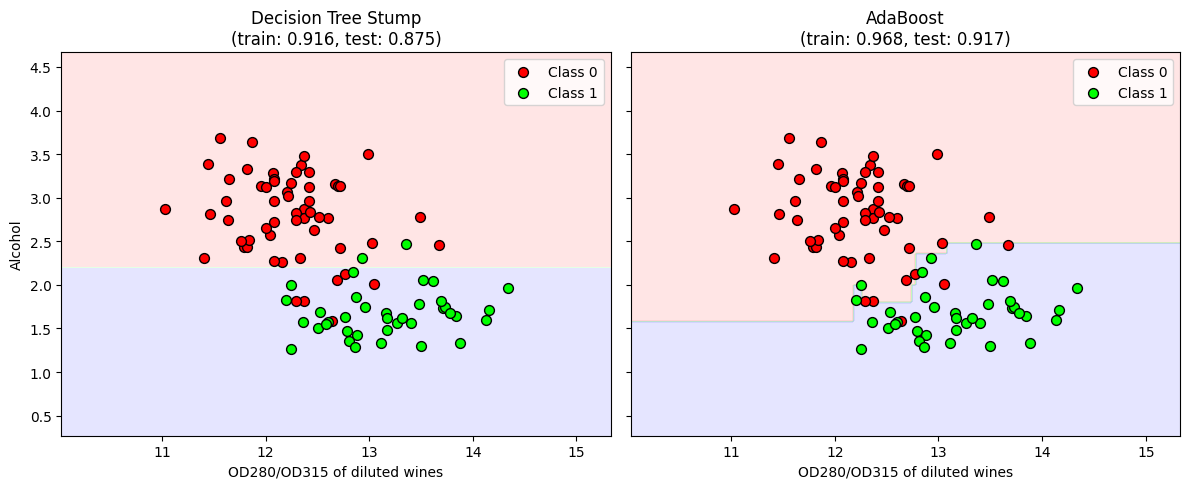

In [23]:
#PART 3: Implementing AdaBoost Classifier

#Step 3.2: Implement AdaBoost Classifier

from sklearn.ensemble import AdaBoostClassifier

# Create decision tree stump
tree_stump = DecisionTreeClassifier(criterion='entropy', 
                                    random_state=1, 
                                    max_depth=1)

# Create AdaBoost classifier
ada = AdaBoostClassifier(estimator=tree_stump,
                         n_estimators=500, 
                         learning_rate=0.1, 
                         random_state=1)

# Train individual decision tree stump
tree_stump = tree_stump.fit(X_train, y_train)
y_train_pred = tree_stump.predict(X_train)
y_test_pred = tree_stump.predict(X_test)
tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('Decision tree stump train/test accuracies %.3f/%.3f' % (tree_train, tree_test))

# Train AdaBoost classifier
ada = ada.fit(X_train, y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)
ada_train = accuracy_score(y_train, y_train_pred) 
ada_test = accuracy_score(y_test, y_test_pred)
print('AdaBoost train/test accuracies %.3f/%.3f' % (ada_train, ada_test))

# Create visualization for decision boundaries
fig, axes = plt.subplots(nrows=1, ncols=2, 
                         sharex='col', 
                         sharey='row', 
                         figsize=(12, 5))

# Plot decision tree stump
Z_stump = tree_stump.predict(np.c_[xx.ravel(), yy.ravel()])
Z_stump = Z_stump.reshape(xx.shape)
axes[0].contourf(xx, yy, Z_stump, alpha=0.3, cmap=cmap_light)
for class_val in np.unique(y_train):
    class_mask = (y_train == class_val)
    axes[0].scatter(X_train[class_mask, 0], 
                   X_train[class_mask, 1],
                   c=cmap_bold(class_val), 
                   label='Class %d' % class_val,
                   edgecolor='k', 
                   s=50)
axes[0].set_title('Decision Tree Stump\n(train: %.3f, test: %.3f)' % (tree_train, tree_test))
axes[0].set_xlabel('OD280/OD315 of diluted wines')
axes[0].set_ylabel('Alcohol')
axes[0].legend()

# Plot AdaBoost
Z_ada = ada.predict(np.c_[xx.ravel(), yy.ravel()])
Z_ada = Z_ada.reshape(xx.shape)
axes[1].contourf(xx, yy, Z_ada, alpha=0.3, cmap=cmap_light)
for class_val in np.unique(y_train):
    class_mask = (y_train == class_val)
    axes[1].scatter(X_train[class_mask, 0], 
                   X_train[class_mask, 1],
                   c=cmap_bold(class_val), 
                   label='Class %d' % class_val,
                   edgecolor='k', 
                   s=50)
axes[1].set_title('AdaBoost\n(train: %.3f, test: %.3f)' % (ada_train, ada_test))
axes[1].set_xlabel('OD280/OD315 of diluted wines')
axes[1].legend()

plt.tight_layout()
plt.show()

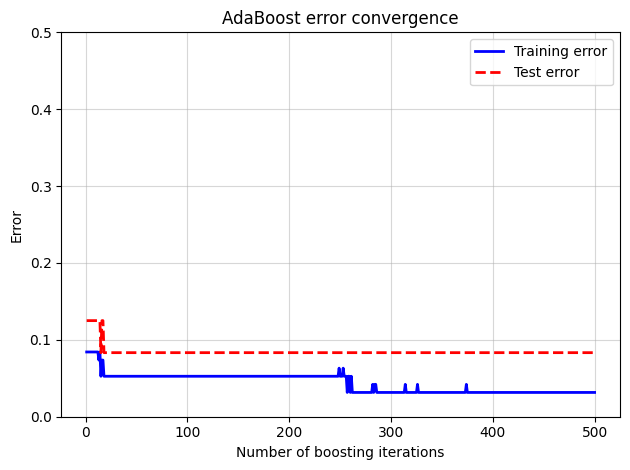

Minimum test error: 0.083 at iteration 15


In [18]:
#Step 3.3: Enhanced Error Convergence Analysis with Multiple Learning Rates

# Plot error convergence for AdaBoost
ada_conv = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1, 
                                                              criterion='entropy',
                                                              random_state=1),
                             n_estimators=500, 
                             learning_rate=0.1, 
                             random_state=1)

ada_conv.fit(X_train, y_train)
ada_train_err = []
ada_test_err = []

for y_train_pred, y_test_pred in zip(ada_conv.staged_predict(X_train), 
                                    ada_conv.staged_predict(X_test)):
    ada_train_err.append(1 - accuracy_score(y_train, y_train_pred))
    ada_test_err.append(1 - accuracy_score(y_test, y_test_pred))

plt.plot(range(1, len(ada_train_err) + 1), 
         ada_train_err, 
         label='Training error',
         color='blue', 
         linestyle='-',
         linewidth=2)

plt.plot(range(1, len(ada_test_err) + 1), 
         ada_test_err, 
         label='Test error',
         color='red', 
         linestyle='--',
         linewidth=2)

plt.xlabel('Number of boosting iterations')
plt.ylabel('Error')
plt.legend(loc='upper right')
plt.ylim(0, 0.5)
plt.grid(alpha=0.5)
plt.title('AdaBoost error convergence')
plt.tight_layout()
plt.show()

# Find optimal iteration
min_test_error_idx = np.argmin(ada_test_err)
min_test_error = ada_test_err[min_test_error_idx]
print('Minimum test error: %.3f at iteration %d' % (min_test_error, min_test_error_idx + 1))

In [20]:
#Step 4.1: Comprehensive Comparison

from sklearn.ensemble import RandomForestClassifier, VotingClassifier

# Prepare Iris dataset for comprehensive comparison
iris_full = datasets.load_iris()
X_full, y_full = iris_full.data, iris_full.target
X_train_full, X_test_full, y_train_full, y_test_full =\
       train_test_split(X_full, y_full,
                        test_size=0.3,
                        random_state=1,
                        stratify=y_full)

# Create individual classifiers
clf_lr = LogisticRegression(random_state=1,
                            max_iter=1000)
clf_knn = KNeighborsClassifier()
clf_dt = DecisionTreeClassifier(random_state=1)
clf_rf = RandomForestClassifier(random_state=1)

# Create ensemble methods
voting_clf = VotingClassifier(estimators=[
    ('lr', clf_lr), ('knn', clf_knn), ('dt', clf_dt), ('rf', clf_rf)], 
    voting='hard')

bagging_clf = BaggingClassifier(estimator=clf_dt,
                               n_estimators=100,
                               random_state=1)

adaboost_clf = AdaBoostClassifier(estimator=clf_dt,
                                 n_estimators=100,
                                 random_state=1)

classifiers = [clf_lr, clf_knn, clf_dt, clf_rf, voting_clf, bagging_clf, adaboost_clf]
classifier_names = ['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 
                    'Voting Classifier', 'Bagging', 'AdaBoost']

# Evaluate all classifiers
results = []
for clf, name in zip(classifiers, classifier_names):
    scores = cross_val_score(clf, 
                            X_train_full, 
                            y_train_full, 
                            cv=10, 
                            scoring='accuracy')
    results.append({
        'Classifier': name,
        'Mean Accuracy': scores.mean(),
        'Std Accuracy': scores.std()
    })

results_df = pd.DataFrame(results)
print('\nClassifier Performance Comparison:')
print('=' * 50)
print(results_df.sort_values('Mean Accuracy', ascending=False))


Classifier Performance Comparison:
            Classifier  Mean Accuracy  Std Accuracy
1                  KNN       0.951818      0.048285
0  Logistic Regression       0.941818      0.047621
4    Voting Classifier       0.940909      0.065839
5              Bagging       0.940909      0.065839
3        Random Forest       0.931818      0.063278
2        Decision Tree       0.922727      0.059231
6             AdaBoost       0.922727      0.071841


AdaBoost Best parameters:  {'learning_rate': 0.1, 'n_estimators': 50}
AdaBoost Best score: 0.971
Bagging Best parameters:  {'max_features': 0.8, 'max_samples': 0.5, 'n_estimators': 200}
Bagging Best score: 0.952

Tuned Model Performance:
AdaBoost (tuned): Mean Accuracy = 0.971 (+/- 0.038)
Bagging (tuned): Mean Accuracy = 0.952 (+/- 0.043)


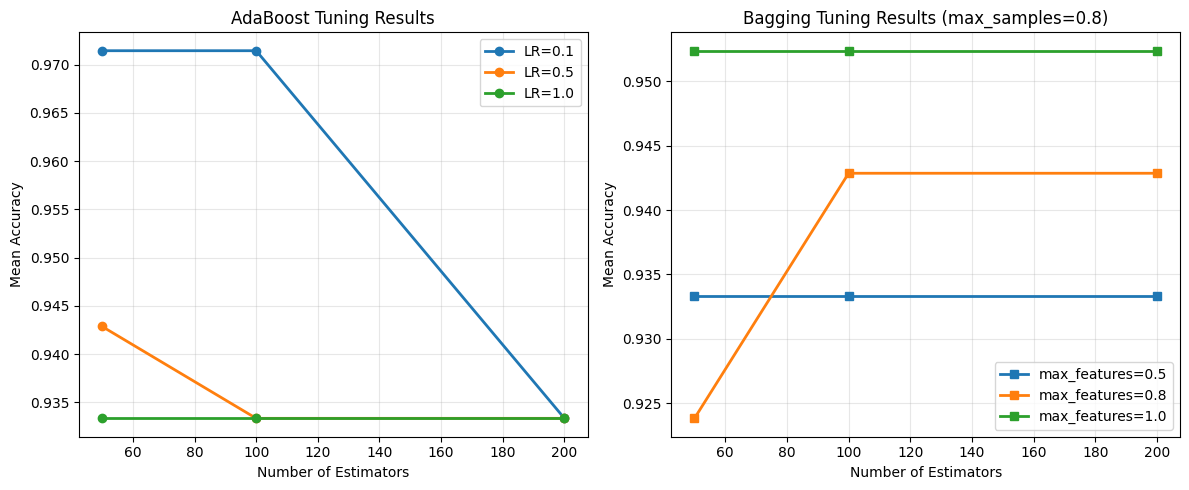


Final Test Set Performance:
AdaBoost (tuned) Test Accuracy: 0.978
Bagging (tuned) Test Accuracy: 0.978
Decision Tree (baseline) Test Accuracy: 0.978


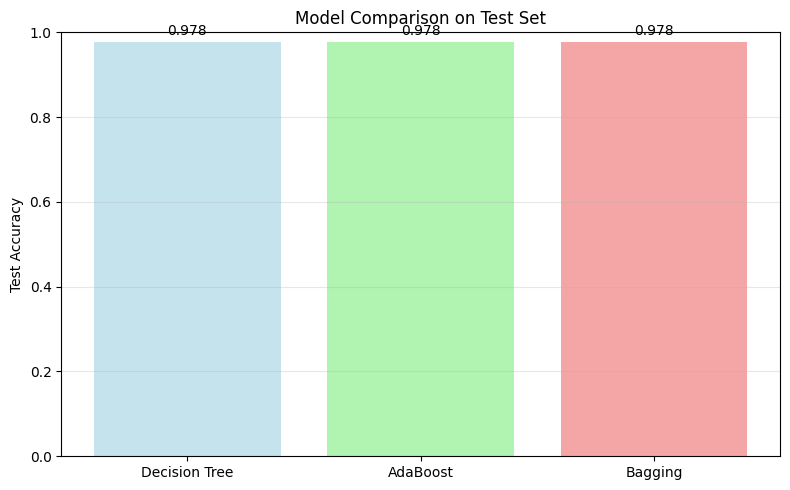


Improvement over Decision Tree:
AdaBoost Improvement: +0.0%
Bagging Improvement: +0.0%


In [26]:
#Step 4.2: Hyperparameter Tuning and Visualization

from sklearn.model_selection import GridSearchCV

# Tune AdaBoost parameters
param_grid_ada = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.1, 0.5, 1.0]
}

ada_base = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1,
                                                              random_state=1),
                             random_state=1)

gs_ada = GridSearchCV(estimator=ada_base,
                      param_grid=param_grid_ada,
                      cv=5,
                      scoring='accuracy',
                      n_jobs=-1)

gs_ada.fit(X_train_full, y_train_full)

print("AdaBoost Best parameters: ", gs_ada.best_params_)
print("AdaBoost Best score: %.3f" % gs_ada.best_score_)

# Tune Bagging parameters
param_grid_bag = {
    'n_estimators': [50, 100, 200],
    'max_samples': [0.5, 0.8, 1.0],
    'max_features': [0.5, 0.8, 1.0]
}

bag_base = BaggingClassifier(estimator=DecisionTreeClassifier(random_state=1),
                            random_state=1)

gs_bag = GridSearchCV(estimator=bag_base,
                      param_grid=param_grid_bag,
                      cv=5,
                      scoring='accuracy',
                      n_jobs=-1)

gs_bag.fit(X_train_full, y_train_full)

print("Bagging Best parameters: ", gs_bag.best_params_)
print("Bagging Best score: %.3f" % gs_bag.best_score_)

# Compare tuned models
tuned_models = {
    'AdaBoost (tuned)': gs_ada.best_estimator_,
    'Bagging (tuned)': gs_bag.best_estimator_
}

print('\nTuned Model Performance:')
print('=' * 40)
for name, model in tuned_models.items():
    scores = cross_val_score(estimator=model,
                            X=X_train_full,
                            y=y_train_full,
                            cv=5,
                            scoring='accuracy')
    print("%s: Mean Accuracy = %.3f (+/- %.3f)" 
          % (name, scores.mean(), scores.std()))

# Simple visualization of tuning results
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# AdaBoost results
ada_results = pd.DataFrame(gs_ada.cv_results_)
for lr in [0.1, 0.5, 1.0]:
    lr_mask = ada_results['param_learning_rate'] == lr
    axes[0].plot(ada_results[lr_mask]['param_n_estimators'],
                ada_results[lr_mask]['mean_test_score'],
                marker='o',
                label='LR=%.1f' % lr,
                linewidth=2)

axes[0].set_xlabel('Number of Estimators')
axes[0].set_ylabel('Mean Accuracy')
axes[0].set_title('AdaBoost Tuning Results')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Bagging results (show for fixed max_samples=0.8)
bag_results = pd.DataFrame(gs_bag.cv_results_)
sample_mask = bag_results['param_max_samples'] == 0.8
feature_values = sorted(bag_results[sample_mask]['param_max_features'].unique())

for feature_val in feature_values:
    feature_mask = sample_mask & (bag_results['param_max_features'] == feature_val)
    axes[1].plot(bag_results[feature_mask]['param_n_estimators'],
                bag_results[feature_mask]['mean_test_score'],
                marker='s',
                label='max_features=%.1f' % feature_val,
                linewidth=2)

axes[1].set_xlabel('Number of Estimators')
axes[1].set_ylabel('Mean Accuracy')
axes[1].set_title('Bagging Tuning Results (max_samples=0.8)')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Final test set evaluation
best_ada = gs_ada.best_estimator_
best_bag = gs_bag.best_estimator_

best_ada.fit(X_train_full, y_train_full)
best_bag.fit(X_train_full, y_train_full)

y_pred_ada = best_ada.predict(X_test_full)
y_pred_bag = best_bag.predict(X_test_full)

ada_test_acc = accuracy_score(y_test_full, y_pred_ada)
bag_test_acc = accuracy_score(y_test_full, y_pred_bag)

print('\nFinal Test Set Performance:')
print('=' * 40)
print("AdaBoost (tuned) Test Accuracy: %.3f" % ada_test_acc)
print("Bagging (tuned) Test Accuracy: %.3f" % bag_test_acc)

# Compare with baseline decision tree
baseline_dt = DecisionTreeClassifier(random_state=1)
baseline_dt.fit(X_train_full, y_train_full)
y_pred_dt = baseline_dt.predict(X_test_full)
dt_test_acc = accuracy_score(y_test_full, y_pred_dt)

print("Decision Tree (baseline) Test Accuracy: %.3f" % dt_test_acc)

# Simple bar chart comparison
models = ['Decision Tree', 'AdaBoost', 'Bagging']
accuracies = [dt_test_acc, ada_test_acc, bag_test_acc]

plt.figure(figsize=(8, 5))
bars = plt.bar(models, accuracies, color=['lightblue', 'lightgreen', 'lightcoral'], alpha=0.7)

plt.ylabel('Test Accuracy')
plt.title('Model Comparison on Test Set')
plt.ylim(0, 1.0)

# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             '%.3f' % acc, ha='center', va='bottom')

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Improvement analysis
ada_improvement = ((ada_test_acc - dt_test_acc) / dt_test_acc) * 100
bag_improvement = ((bag_test_acc - dt_test_acc) / dt_test_acc) * 100

print('\nImprovement over Decision Tree:')
print('=' * 40)
print("AdaBoost Improvement: +%.1f%%" % ada_improvement)
print("Bagging Improvement: +%.1f%%" % bag_improvement)